## Building our own data Pipe lines 

#### Install these Dependecies to ensure the code runs. 

In [118]:
# pip install fuzzywuzzy
# pip install unicodedata2
# pip install soccerplots


# TODO: CLEAN CODE AND ENSURE CLEAN RUN THROUGH

In [20]:
# %matplotlib inline


import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
import matplotlib.style as style
import matplotlib as mpl
import matplotlib.patheffects as pe
import warnings
import requests
import os
import numpy as np
from math import pi
from bs4 import BeautifulSoup
from urllib.request import urlopen
from highlight_text import fig_text
from adjustText import adjust_text
from soccerplots.radar_chart import Radar
from mplsoccer import PyPizza, add_image, FontManager

style.use('fivethirtyeight')


# import mplcyberpunk
# plt.style.use("cyberpunk")

In [21]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=97, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [22]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii = str(only_ascii)
    only_ascii = only_ascii[2:-1]
    only_ascii = only_ascii.replace('-', ' ')
    return only_ascii


In [23]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database


In [28]:
team_urls = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
full_urls = list(team_urls.urls.unique())

In [25]:
# test function - written offline - not tested yet 

# def full_urls (url_string: str):
#     links = get_team_urls(url_string)  
#     full_urls = list(links.urls.unique())
#     return full_urls


In [39]:
import time 
def general_url_database(full_urls):    
    appended_data = []
    for team_url in full_urls:
        # url = team_url
        print(team_url)
        player_db = pd.DataFrame()
        player_urls = []
        # data  = requests.get(team_url).text
        links = BeautifulSoup(requests.get(team_url).text).select('th a')
        urls = [link['href'] for link in links]
        player_urls.append(urls)
        player_urls  = [item for sublist in player_urls  for item in sublist]
        player_urls.sort()
        player_urls = list(set(player_urls))
        p_url = list(filter(lambda k: 'players' in k, player_urls))
        url_final = []
        for y in p_url:
            full_url = "https://fbref.com"+y
            url_final.append(full_url)
        player_names = []
        for player in p_url: 
            player_name_slice = player[21:]
            player_name_slice = player_name_slice.replace('-', ' ')
            player_names.append(player_name_slice)
        # player_names
        list_of_tuples = list(zip(player_names, url_final))
        play_url_database = pd.DataFrame(list_of_tuples, columns = ['Player', 'urls'])
        player_db = pd.concat([play_url_database])

        # # html = requests.get(url).text
        # data2 = BeautifulSoup(requests.get(url).text, 'html5')
        table = BeautifulSoup(requests.get(team_url).text, 'html5').find('table')
        cols = []

        for header in table.find_all('th'):
            cols.append(header.string)

        if len(cols) == 59: 
            columns = cols[8:37] #gets necessary column headers
            players = cols[37:-2]
        else: 
            columns = cols[9:38] #gets necessary column headers
            players = cols[38:-2]

        #display(columns)
        rows = [] #initliaze list to store all rows of data
        for rownum, row in enumerate(table.find_all('tr')): #find all rows in table
            if len(row.find_all('td')) > 0: 
                rowdata = [] #initiliaze list of row data
                for i in range(0,len(row.find_all('td'))): #get all column values for row
                    rowdata.append(row.find_all('td')[i].text)
                rows.append(rowdata)
        df = pd.DataFrame(rows, columns=columns)

        df.drop(df.tail(2).index,inplace=True)
        df["Player"] = players
        df = df[["Player","Pos","Age", "Starts"]]

        df['Player'] = df.apply(lambda x: remove_accents(x['Player']), axis=1)
        test_merge = fuzzy_merge(df, player_db, 'Player', 'Player', threshold=90)
        test_merge = test_merge.rename(columns={'matches': 'Player', 'Player': 'matches'})
        # test_merge = test_merge.drop(columns=['matches'])
        final_merge = test_merge.merge(player_db, on='Player', how='left')
        del df, table
        time.sleep(10)
        # list_of_dfs.append(final_merge)
    appended_data.append(final_merge)
    appended_data = pd.concat(appended_data)
    return appended_data 

In [40]:
EPL_Player_db = general_url_database(full_urls)

In [ ]:
def years_converter(variable_value):
    if len(variable_value) > 3:
        years = variable_value[:-4]
        days = variable_value[3:]
        years_value = pd.to_numeric(years)
        days_value = pd.to_numeric(days)
        day_conv = days_value/365
        final_val = years_value + day_conv
    else:
        final_val = pd.to_numeric(variable_value)

    return final_val

EPL_Player_db['Age'] = EPL_Player_db.apply(lambda x: years_converter(x['Age']), axis=1)
EPL_Player_db = EPL_Player_db.drop(columns=['matches'])

In [ ]:
def get_360_scouting_report(url):    
    start = url[0:38]+ "scout/365_euro/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 38)
    final_string = start+mod_string+"-Scouting-Report"    
    return final_string
EPL_Player_db['scouting_url'] = EPL_Player_db.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)

In [ ]:
keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
defensive_mids = ['MF,DF']
midfielders = ['MF']
attacking_mids = ['MF,FW',"FW,MF"]
forwards = ['FW']
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in defensive_mids:
        return "Defensive-Midfielders"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in attacking_mids:
        return "Attacking Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

EPL_Player_db["position_group"] = EPL_Player_db.Pos.apply(lambda x: position_grouping(x))
EPL_Player_db.reset_index(drop=True)
EPL_Player_db[["Starts"]] = EPL_Player_db[["Starts"]].apply(pd.to_numeric) 

In [ ]:
position = 'Central Midfielders'
pl_starts = 10
max_age = 26

In [221]:
subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )

In [222]:
players_needed = list(subset_of_data.urls.unique())

In [223]:
def get_player_multi_data(url_list:list):
    appended_data = []
    for url in url_list:
        warnings.filterwarnings("ignore")
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        metric_names = []
        metric_values = []
        remove_content = ["'", "[", "]", ","]
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('th')[0].contents
            metric_names.append(first_column)
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('td')[0].contents
            metric_values.append(first_column)

        metric_names = [item for sublist in metric_names for item in sublist]
        metric_values = [item for sublist in metric_values for item in sublist]

        df_player = pd.DataFrame()
        df_player['Name'] = name[0]
        for item in metric_names:
            df_player[item] = []

        name = name
        non_penalty_goals = (metric_values[0])
        npx_g = metric_values[1]
        shots_total = metric_values[2]
        assists = metric_values[3]
        x_a = metric_values[4]
        npx_g_plus_x_a = metric_values[5] 
        shot_creating_actions = metric_values[6] 
        passes_attempted = metric_values[7] 
        pass_completion_percent = metric_values[8] 
        progressive_passes = metric_values[9] 
        progressive_carries = metric_values[10] 
        dribbles_completed = metric_values[11] 
        touches_att_pen = metric_values[12]
        progressive_passes_rec = metric_values[13] 
        pressures = metric_values[14] 
        tackles = metric_values[15] 
        interceptions = metric_values[16] 
        blocks = metric_values[17]
        clearances = metric_values[18]
        aerials_won = metric_values[19]
        df_player.loc[0] = [name, non_penalty_goals, npx_g, shots_total, assists, x_a, npx_g_plus_x_a, shot_creating_actions, passes_attempted, pass_completion_percent,
                            progressive_passes, progressive_carries, dribbles_completed, touches_att_pen, progressive_passes_rec, pressures, tackles, interceptions, blocks,
                            clearances, aerials_won]
        appended_data.append(df_player)
    appended_data = pd.concat(appended_data)
    return appended_data

In [41]:
df = get_player_multi_data(players_needed)

In [ ]:
def metrics_scatter_comparison(df, max_age, position):
        
        df[['Progressive Passes', 'Progressive Carries','Passes Attempted']] =  df[['Progressive Passes','Progressive Carries','Passes Attempted']].apply(pd.to_numeric)         
        df["Progressive_Actions_p90"] = df['Progressive Passes'] + df['Progressive Carries']
        df["Passes_Attempted"] = df['Passes Attempted']

        line_color = "silver"

        # with cbook.get_sample_data('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/logo_transparent_background.png') as file:
        #         im = image.imread(file)

        style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=(12, 8)) 
        ax.scatter(df["Progressive_Actions_p90"], df["Passes_Attempted"],alpha=0.8,marker="1") ##scatter points
        ax.axvspan(10.0, 14.0, ymin=0.5, ymax=1, alpha=0.1, color='green',label= "In Form")

        texts = [] ##plot player names
        for row in df.itertuples():
                texts.append(ax.text(row.Progressive_Actions_p90, row.Passes_Attempted, row.Name, fontsize=8, ha='center', va='center', zorder=10))
                adjust_text(texts,force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='red'),
            autoalign='y',
            only_move={'points':'y','text':'y'})  ## to remove overlaps between labels

        ## update plot
                ax.set(xlabel="Progressive Actions per 90", ylabel="Passes Attempted per 90", ylim=((df["Passes_Attempted"].min()-2), (df["Passes_Attempted"].max()+2)), xlim=((df["Progressive_Actions_p90"].min()-2), (df["Progressive_Actions_p90"].max()+2))) ## set labels and limits

        ##grids and spines
        ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
        for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
                ax.spines[spine].set_color(line_color)

        ax.xaxis.label.set(fontsize=12, fontweight='bold')
        ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

        ax.set_position([0.05, 0.05, 0.82, 0.78]) ## make space for the title on top of the axes

        ## title and subtitle
        fig.text(x=0.08, y=0.92, s=f"U-{max_age} {position} | Progressive Actions Profile", 
                 ha='left', fontsize=20, fontweight='book') 
        fig.text(x=0.08, y=0.88, s=f"EPL | 2021-22", ha='left', 
                fontsize=16, fontweight='book')
        
        # fig.figimage(im, 10, 10, zorder=3, alpha=.5,resize=True)

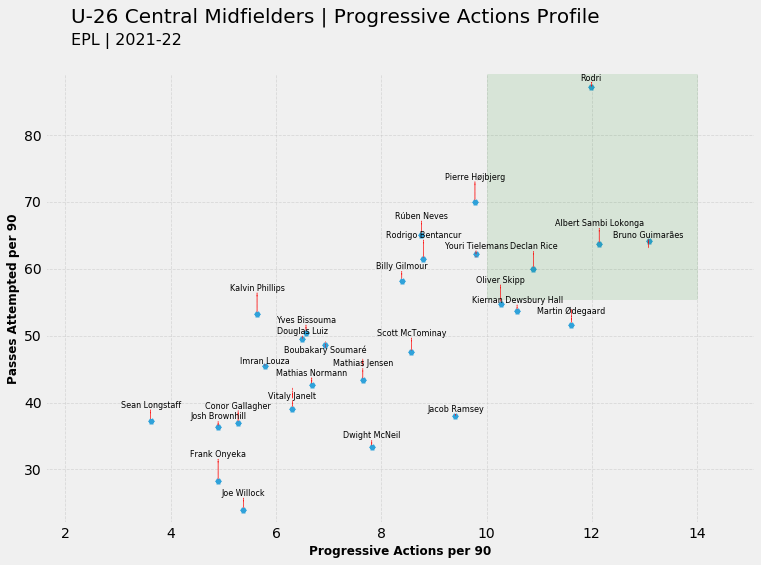

In [ ]:
metrics_scatter_comparison(df, max_age, position)

In [225]:
scout_links = list(subset_of_data.scouting_url.unique())

In [226]:
def generate_advanced_data(scout_links):
    appended_data_per90 = []
    appended_data_percent = []
    for x in scout_links:
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
        df = pd.read_html(html_content)
        df[0].columns = df[0].columns.droplevel(0) # drop top header row
        stats = df[0]
        advanced_stats = stats.loc[(stats['Statistic'] != "Statistic" ) & (stats['Statistic'] != ' ')]
        advanced_stats = advanced_stats.dropna(subset=['Statistic',"Per 90", "Percentile"])
        per_90_df = advanced_stats[['Statistic',"Per 90",]].set_index("Statistic").T
        per_90_df["Name"] = name
        percentile_df = advanced_stats[['Statistic',"Percentile",]].set_index("Statistic").T
        percentile_df["Name"] = name
        appended_data_per90.append(per_90_df)
        appended_data_percent.append(percentile_df)
    appended_data_per90 = pd.concat(appended_data_per90)
    appended_data_per90 = appended_data_per90.reset_index(drop=True)
    del appended_data_per90.columns.name
    appended_data_per90 = appended_data_per90[['Name'] + [col for col in appended_data_per90.columns if col != 'Name']]
    appended_data_per90 = appended_data_per90.loc[:,~appended_data_per90.columns.duplicated()]
    appended_data_percentile = pd.concat(appended_data_percent)
    appended_data_percentile = appended_data_percentile.reset_index(drop=True)
    del appended_data_percentile.columns.name
    appended_data_percentile = appended_data_percentile[['Name'] + [col for col in appended_data_percentile.columns if col != 'Name']]
    appended_data_percentile = appended_data_percentile.loc[:,~appended_data_percentile.columns.duplicated()]
    list_of_dfs = [appended_data_per90,appended_data_percentile]
    return list_of_dfs



In [42]:
appended_data_per90 = generate_advanced_data(scout_links)[0]

In [ ]:
attacking = ["Name",'Goals', 'Assists', 'Non-Penalty Goals','Penalty Kicks Attempted', 'xG',
      'xA', 'npxG+xA', 'Shots Total', 'Shots on target', 'npxG/Sh',
       'Goals - xG', 'Non-Penalty Goals - npxG']
passing = ["Name", 'Passes Completed','Passes Attempted', 'Total Passing Distance',
       'Progressive Passing Distance', 
       'Key Passes', 'Passes into Final Third',
       'Passes into Penalty Area', 'Crosses into Penalty Area',
       'Progressive Passes']
pass_length = ['Passes Completed (Short)',
       'Passes Attempted (Short)', 'Pass Completion % (Short)',
       'Passes Completed (Medium)', 'Passes Attempted (Medium)',
       'Pass Completion % (Medium)', 'Passes Completed (Long)',
       'Passes Attempted (Long)', 'Pass Completion % (Long)']       
pass_types = ["Name", 'Live-ball passes', 'Dead-ball passes',
       'Passes from Free Kicks', 'Through Balls', 'Passes Under Pressure',
       'Switches', 'Crosses', 'Corner Kicks', 'Inswinging Corner Kicks',
       'Outswinging Corner Kicks', 'Straight Corner Kicks',
       'Ground passes', 'Low Passes', 'High Passes',
       'Passes Attempted (Left)', 'Passes Attempted (Right)',
       'Passes Attempted (Head)', 'Throw-Ins taken',
       'Passes Attempted (Other)', 'Passes Offside',
       'Passes Out of Bounds', 'Passes Intercepted', 'Passes Blocked']
chance_creation = ["Name",'Shot-Creating Actions', 'SCA (PassLive)', 'SCA (PassDead)',
       'SCA (Drib)', 'SCA (Sh)', 'SCA (Fld)', 'SCA (Def)',
       'Goal-Creating Actions', 'GCA (PassLive)', 'GCA (PassDead)',
       'GCA (Drib)', 'GCA (Sh)', 'GCA (Fld)', 'GCA (Def)']
defending = [ "Name", 'Tackles',
       'Tackles Won',  'Dribblers Tackled', 'Dribbled Past', 'Pressures',
       'Successful Pressures',
       'Blocks', 'Shots Blocked', 'Shots Saved',
       'Interceptions', 'Tkl+Int', 'Clearances', 'Errors','Ball Recoveries',
       'Aerials won', 'Aerials lost']
possesion = ["Name", 'Touches',
       'Dribbles Completed', 'Dribbles Attempted',
       'Players Dribbled Past',
       'Total Carrying Distance', 'Progressive Carrying Distance',
       'Progressive Carries', 'Carries into Final Third', 'Miscontrols', 'Dispossessed',
       'Passes Received',
       'Progressive Passes Rec']
dicipline = ["Name", 'Yellow Cards', 'Red Cards','Second Yellow Card', 'Fouls Committed','Offsides','Penalty Kicks Conceded', 'Own Goals']
smarts = ["Name",'Penalty Kicks Won','Fouls Drawn']


In [205]:
per_90_dataframe = appended_data_per90[possesion]
per_90_dataframe

,Name,Touches,Dribbles Completed,Dribbles Attempted,Players Dribbled Past,Total Carrying Distance,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec
0,Vitaly Janelt,49.19,0.67,0.86,0.71,136.57,68.26,2.55,0.78,1.02,0.47,29.26,2.11
1,Mathias Jensen,53.69,0.67,1.12,0.79,143.29,69.54,3.77,1.12,0.84,1.18,31.37,2.81
2,Frank Onyeka,40.39,0.78,1.21,0.86,142.28,74.41,3.01,0.78,0.95,1.55,23.43,2.58
3,Kalvin Phillips,66.09,0.45,0.73,0.56,179.21,67.16,1.52,0.68,0.56,1.02,40.04,0.96
4,Pierre Højbjerg,80.12,1.13,1.61,1.15,248.99,125.34,4.06,1.10,0.68,0.76,58.24,1.44
5,Rodrigo Bentancur,72.30,0.56,0.90,0.62,246.12,120.41,4.51,1.49,0.75,1.34,52.74,1.99
6,Oliver Skipp,63.47,0.13,0.20,0.13,208.13,114.13,5.67,1.93,0.53,0.87,46.00,0.87
7,Declan Rice,70.28,1.08,1.70,1.17,350.77,174.70,6.63,2.36,0.60,0.77,49.32,0.99
8,Martin Ødegaard,60.43,0.71,1.36,0.74,218.94,116.73,6.50,2.04,1.39,1.58,44.95,3.78
9,Albert Sambi Lokonga,73.81,0.32,0.56,0.32,306.43,165.95,7.30,1.75,0.79,0.56,54.68,1.35


In [206]:
names = ["Albert Sambi Lokonga","Yves Bissouma"]
per_90_dataframe = per_90_dataframe[per_90_dataframe.Name.isin(names)]
per_90_dataframe

,Name,Touches,Dribbles Completed,Dribbles Attempted,Players Dribbled Past,Total Carrying Distance,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec
9,Albert Sambi Lokonga,73.81,0.32,0.56,0.32,306.43,165.95,7.30,1.75,0.79,0.56,54.68,1.35
19,Yves Bissouma,63.27,1.32,1.88,1.32,250.18,118.14,4.35,1.75,1.19,1.28,41.40,0.64


Text(0.99, 0.005, '@stephenaq7\ndata via FBREF / Statsbomb\ninspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314')

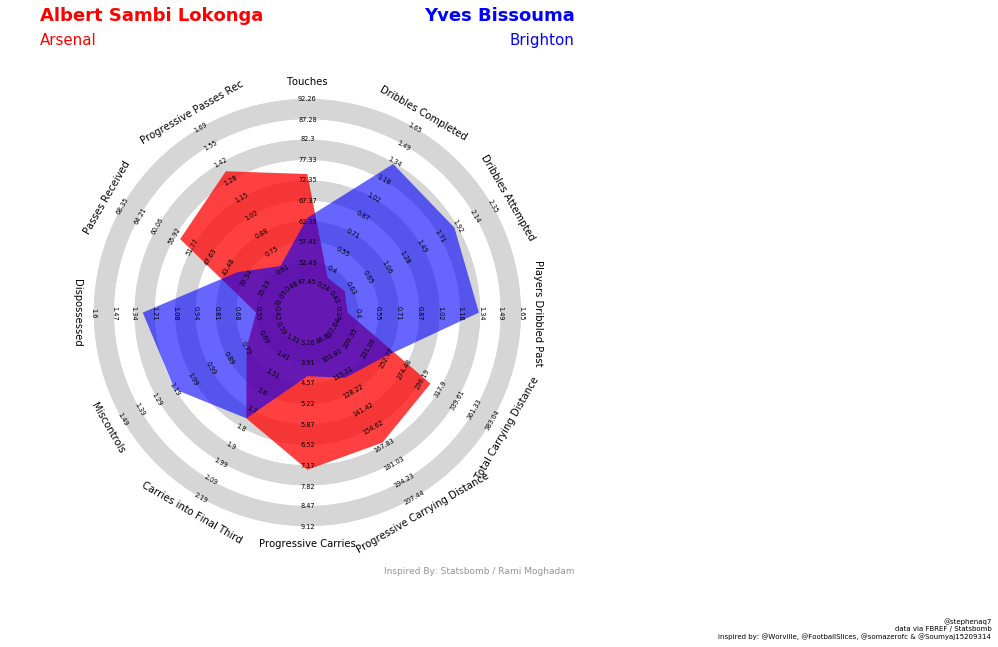

In [207]:
player_names = ["Albert Sambi Lokonga","Yves Bissouma"]
per_90_dataframe.reset_index(drop=True)
per_90_dataframe = per_90_dataframe[per_90_dataframe.Name.isin(names)]
cols = per_90_dataframe.columns.drop('Name')
per_90_dataframe[cols] = per_90_dataframe[cols].apply(pd.to_numeric)
params = list(per_90_dataframe.columns)
params = params[1:]
params

ranges = []
a_values = []
b_values = []

for x in params:
    a = min(per_90_dataframe[params][x])
    a = a - (a* 0.25)
    
    b = max(per_90_dataframe[params][x])
    b = b + (b* 0.25)
    
    ranges.append((a,b))
    
a_values = per_90_dataframe.iloc[0].values.tolist()

b_values = per_90_dataframe.iloc[1].values.tolist()
        
a_values = a_values[1:]
b_values = b_values[1:]

values = [a_values,b_values]

get_clubs = subset_of_data[subset_of_data.Player.isin(player_names)]
link_list = list(get_clubs.urls.unique())
title_vars = []
for x in link_list:     
    warnings.filterwarnings("ignore")
    html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
    df2 = pd.read_html(html_content)
    df2[5].columns = df2[5].columns.droplevel(0) 
    stats2 = df2[5]
    key_vars = stats2[["Season","Age","Squad"]]
    key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
    title_vars.append(key_vars)
title_vars = pd.concat(title_vars)
ages = list(title_vars.Age.unique())
teams = list(title_vars.Squad.unique())

#title 

title = dict(
    title_name= player_names[0],
    title_color = 'red',
    subtitle_name = teams[0],
    subtitle_color = 'red',

    title_name_2= player_names[1],
    title_color_2 = 'blue',
    subtitle_name_2 = teams[1],
    subtitle_color_2 = 'blue',
    title_fontsize = 18,
    subtitle_fontsize=15
)


CREDIT_1 = '@stephenaq7\ndata via FBREF / Statsbomb'
CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"



radar = Radar()

# with cbook.get_sample_data('logo_transparent_background.png') as file:
#                 im = image.imread(file)

style.use('fivethirtyeight')
fig,ax = radar.plot_radar(ranges=ranges,params=params,values=values,
                         radar_color=['red','blue'],
                         alphas=[.75,.6],title=title,
                         compare=True)
fig.text(
    0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=7,
    color="#000000",
    ha="right"
)
# fig.figimage(im, 10, 10, zorder=3, alpha=.5)

        

In [208]:
def metrics_scatter_comparison(df, max_age, position,x_axis_feature, y_axis_feature, Title):
    x = [y_axis_feature, x_axis_feature]
    df[x] =  df[x].apply(pd.to_numeric) 
    df2 = df[x]
    df2 = df.rename({y_axis_feature: 'Y', x_axis_feature: 'X'}, axis=1)
    return_list = []
    for feature in x: 
            feature = feature.replace(" ", "_")
            return_list.append(feature)
    last_names = []
    for name in df2.Name.unique():
        last_names.append(name.split()[-1])
    df2["surname"]= last_names
    line_color = "silver"
    # with cbook.get_sample_data('logo_transparent_background.png') as file:
    #             im = image.imread(file)

    fig, ax = plt.subplots(figsize=(12, 8)) 
    ax.scatter(df2["X"], df2["Y"],alpha=0.5,marker="1", s=15, c='b') ##scatter points
    ax.axvspan((df2["X"].max()*0.75), (df2["X"].max()), ymin=0.75, ymax=1, alpha=0.1, color='green',label= "In Form")

    texts = [] ##plot player names
    for row in df2.itertuples():
            texts.append(ax.text(row.X, row.Y, row.surname, fontsize=8, ha='center', va='center', zorder=10))
            adjust_text(texts,force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='red'),
            autoalign='y',
            only_move={'points':'y','text':'y'})  ## to remove overlaps between labels
    ax.grid(color=line_color, linestyle='--', linewidth=0.8, alpha=0.5)   
    for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
            ax.spines[spine].set_color(line_color)

    ## update plot
            ax.set(xlabel= x_axis_feature, ylabel= y_axis_feature, ylim=((df2["Y"].min()*-0.001), (df2["Y"].max()*1.015)), xlim=((df2["X"].min()), (df2["X"].max()*1.1))) ## set labels and limits

    ax.xaxis.label.set(fontsize=12, fontweight='bold')
    ax.yaxis.label.set(fontsize=12, fontweight='bold') ## increase the weight of the axis labels

    ax.set_position([0.05, 0.05, 0.82, 0.78]) ## make space for the title on top of the axes

    # ## title and subtitle
    fig.text(x=0.08, y=0.92, s=f"U-{max_age} {position} | {Title}", 
                ha='left', fontsize=20, fontweight='book') 
    fig.text(x=0.08, y=0.88, s=f"EPL | 2021-22", ha='left', fontsize=20, fontweight='book')
    # fig.figimage(im, 10, 10, zorder=3, alpha=.5)

In [209]:
# position = 'Forwards'
# pl_starts = 5
# max_age = 30
# attribute = attacking
position = 'Central Midfielders'
pl_starts = int(5)
max_age = int(32)
attribute = passing + possesion + possesion



In [210]:
def create_position_comparison_df(df,position,pl_starts,max_age,attribute): 

    subset_of_data = df.loc[(df['position_group'] == "position") & (df['Starts'] >= pl_starts ) & (df['Age'] <= max_age )]
    scout_links = list(subset_of_data.scouting_url.unique())
    appended_data_per90 = generate_advanced_data(scout_links)[0]
    per_90_dataframe = appended_data_per90[attribute]
    return per_90_dataframe
    

In [211]:
EU_TOP_5_DB[["Starts"]] = EU_TOP_5_DB[["Starts"]].apply(pd.to_numeric) 

In [163]:
# EU_TOP_5_DB['Age'] = EU_TOP_5_DB.apply(lambda x: years_converter(x['Age']), axis=1)

In [164]:
df = create_position_comparison_df(EPL_Player_db,position,pl_starts,max_age,attribute)
df

In [116]:
Title = "Shots on Target vs. xExpected Goals"
x_axis_feature = 'Shots on target'
y_axis_feature = 'xG'

In [212]:
metrics_scatter_comparison(df, max_age, position,x_axis_feature, y_axis_feature, Title)

KeyError: "['xG' 'Shots on target'] not in index"

In [65]:
names = ["Gabriel Jesus","Dominic Calvert-Lewin"]

In [68]:
def radar_comparison(df, names,EPL_Player_db):
    return_list = []
    for name in names: 
            name = name.replace("-", " ")
            return_list.append(name)
    per_90_dataframe = df[df.Name.isin(names)]
    per_90_dataframe.reset_index(drop=True)
    cols = per_90_dataframe.columns.drop('Name')
    per_90_dataframe[cols] = per_90_dataframe[cols].apply(pd.to_numeric)
    params = list(per_90_dataframe.columns)
    params = params[1:]
    

    ranges = []
    a_values = []
    b_values = []

    for x in params:
        a = min(per_90_dataframe[params][x])
        a = a - (a* 0.25)
        
        b = max(per_90_dataframe[params][x])
        b = b + (b* 0.25)
        
        ranges.append((a,b))
        
    a_values = per_90_dataframe.iloc[0].values.tolist()

    b_values = per_90_dataframe.iloc[1].values.tolist()
            
    a_values = a_values[1:]
    b_values = b_values[1:]

    values = [a_values,b_values]

    get_clubs = EPL_Player_db[EPL_Player_db.Player.isin(return_list)]
    link_list = list(get_clubs.urls.unique())
    title_vars = []
    for x in link_list:     
        warnings.filterwarnings("ignore")
        html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
        df2 = pd.read_html(html_content)
        df2[5].columns = df2[5].columns.droplevel(0) 
        stats2 = df2[5]
        key_vars = stats2[["Season","Age","Squad"]]
        key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
        title_vars.append(key_vars)
    title_vars = pd.concat(title_vars)
    ages = list(title_vars.Age.unique())
    teams = list(title_vars.Squad.unique())

    #title 

    title = dict(
        title_name= names[0],
        title_color = 'red',
        subtitle_name = teams[0],
        subtitle_color = 'red',

        title_name_2= names[1],
        title_color_2 = 'blue',
        subtitle_name_2 = teams[1],
        subtitle_color_2 = 'blue',
        title_fontsize = 18,
        subtitle_fontsize=15
    )
    # with cbook.get_sample_data('logo_transparent_background.png') as file:
    #             im = image.imread(file)

    endnote = '@stephenaq7\ndata via FBREF / Statsbomb'

    radar = Radar()
   
    style.use('fivethirtyeight')
    fig,ax = radar.plot_radar(ranges=ranges,params=params,values=values,
                            radar_color=['red','blue'],
                            alphas=[.75,.6],title=title,endnote=endnote,
                            compare=True)
    # fig.figimage(im, 10, 10, zorder=3, alpha=.5)
        

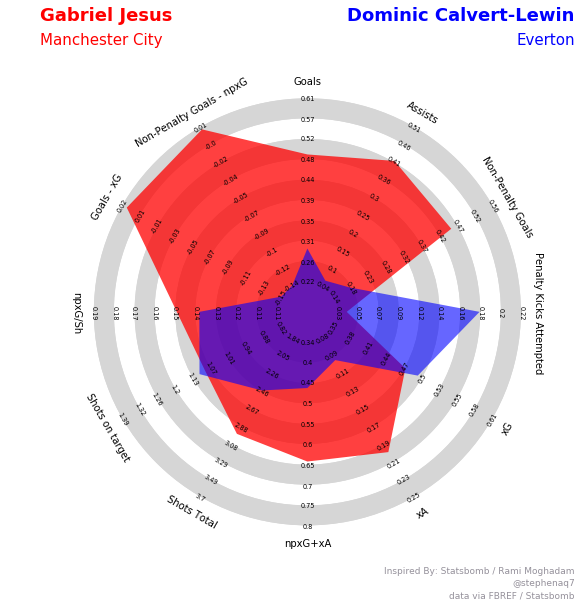

In [69]:
radar_comparison(df, names,EPL_Player_db)

In [63]:
per_90_dataframe = df[df.Name.isin(names)]
per_90_dataframe.reset_index(drop=True)
cols = per_90_dataframe.columns.drop('Name')
per_90_dataframe[cols] = per_90_dataframe[cols].apply(pd.to_numeric)
params = list(per_90_dataframe.columns)
params = params[1:]


ranges = []
a_values = []
b_values = []

for x in params:
    a = min(per_90_dataframe[params][x])
    a = a - (a* 0.25)
    
    b = max(per_90_dataframe[params][x])
    b = b + (b* 0.25)
    
    ranges.append((a,b))
    
a_values = per_90_dataframe.iloc[0].values.tolist()

# b_values = per_90_dataframe.iloc[1].values.tolist()
        
# a_values = a_values[1:]
# b_values = b_values[1:]

# values = [a_values,b_values]

In [64]:
per_90_dataframe

,Name,Goals,Assists,Non-Penalty Goals,Penalty Kicks Attempted,xG,xA,npxG+xA,Shots Total,Shots on target,npxG/Sh,Goals - xG,Non-Penalty Goals - npxG
3,Gabriel Jesus,0.49,0.41,0.45,0.04,0.47,0.2,0.64,2.96,1.09,0.15,0.02,0.01


In [44]:
def create_pizza_chart(EPL_Player_db,player_name,attribute): 

    subset_of_data = EPL_Player_db.query('Player == @player_name' )
    scout_links = list(subset_of_data.scouting_url.unique())
    appended_data_percentile = generate_advanced_data(scout_links)[1]
    appended_data_percentile = appended_data_percentile[attribute]
    cols = appended_data_percentile.columns.drop('Name')
    appended_data_percentile[cols] = appended_data_percentile[cols].apply(pd.to_numeric)
    params = list(appended_data_percentile.columns)
    params = params[1:]


    values = appended_data_percentile.iloc[0].values.tolist()
    values = values[1:]
 
    get_clubs = subset_of_data[subset_of_data.Player.isin([player_name])]
    link_list = list(get_clubs.urls.unique())
    title_vars = []
    for x in link_list:     
        warnings.filterwarnings("ignore")
        html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
        df2 = pd.read_html(html_content)
        df2[5].columns = df2[5].columns.droplevel(0) 
        stats2 = df2[5]
        key_vars = stats2[["Season","Age","Squad"]]
        key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
        title_vars.append(key_vars)
    title_vars = pd.concat(title_vars)
    teams = list(title_vars.Squad.unique())[0]


    style.use('fivethirtyeight')
    baker = PyPizza(
        params=params,                  # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        values,              # list of values
        figsize=(8, 8),      # adjust figsize according to your need
        param_location=110,  # where the parameters will be added
        kwargs_slices=dict(
            facecolor="#6CABDD", edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            va="center", alpha=.5
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="#6CABDD",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    # add title
    fig.text(
        0.515, 0.97, f"{player_name} - {teams}", size=18,
        ha="center", color="#000000"
    )
    general_pos = str(subset_of_data.position_group.unique()[0])
    # add subtitle
    fig.text(
        0.515, 0.942,
        f"Per 90 Percentile Rank vs Premier League {general_pos}| 2021-22",
        size=15,
        ha="center", color="#000000"
    )

    # add credits
    notes = 'Players only with more than 15 90s'
    CREDIT_1 = '@stephenaq7\ndata via FBREF / Statsbomb'
    CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

    fig.text(
        0.99, 0.005, f"{notes}\n{CREDIT_1}\n{CREDIT_2}", size=7,
        color="#000000",
        ha="right"
    )
    # with cbook.get_sample_data('logo_transparent_background.png') as file:
    #             im = image.imread(file)
    
    # fig.figimage(im, 10, 10, zorder=3, alpha=.5)
        
    # plt.savefig('pizza.png',dpi=500,bbox_inches = 'tight')

In [165]:
# create_pizza_chart(EPL_Player_db,"Gabriel Jesus",attacking)

In [ ]:
def radar_comparison_any_player(names,EPL_Player_db,attribute):
    
    subset_of_data = EPL_Player_db[EPL_Player_db.Name.isin(names)]
    scout_links = list(subset_of_data.scouting_url.unique())
    appended_data_per90 = generate_advanced_data(scout_links)[0]
    per_90_dataframe = appended_data_per90[attribute]
   
    
    return_list = []
    for name in names: 
            name = name.replace("-", " ")
            return_list.append(name)
    # per_90_dataframe = df[df.Name.isin(names)]
    per_90_dataframe.reset_index(drop=True)
    cols = per_90_dataframe.columns.drop('Name')
    per_90_dataframe[cols] = per_90_dataframe[cols].apply(pd.to_numeric)
    params = list(per_90_dataframe.columns)
    params = params[1:]
    

    ranges = []
    a_values = []
    b_values = []

    for x in params:
        a = min(per_90_dataframe[params][x])
        a = a - (a* 0.25)
        
        b = max(per_90_dataframe[params][x])
        b = b + (b* 0.25)
        
        ranges.append((a,b))
        
    a_values = per_90_dataframe.iloc[0].values.tolist()

    b_values = per_90_dataframe.iloc[1].values.tolist()
            
    a_values = a_values[1:]
    b_values = b_values[1:]

    values = [a_values,b_values]

    get_clubs = EPL_Player_db[EPL_Player_db.Player.isin(return_list)]
    link_list = list(get_clubs.urls.unique())
    title_vars = []
    for x in link_list:     
        warnings.filterwarnings("ignore")
        html_content = requests.get(x).text.replace('<!--', '').replace('-->', '')
        df2 = pd.read_html(html_content)
        df2[5].columns = df2[5].columns.droplevel(0) 
        stats2 = df2[5]
        key_vars = stats2[["Season","Age","Squad"]]
        key_vars = key_vars[key_vars.Season.isin(["2021-2022"])]
        title_vars.append(key_vars)
    title_vars = pd.concat(title_vars)
    ages = list(title_vars.Age.unique())
    teams = list(title_vars.Squad.unique())

    #title 

    title = dict(
        title_name= names[0],
        title_color = 'red',
        subtitle_name = teams[0],
        subtitle_color = 'red',

        title_name_2= names[1],
        title_color_2 = 'blue',
        subtitle_name_2 = teams[1],
        subtitle_color_2 = 'blue',
        title_fontsize = 18,
        subtitle_fontsize=15
    )
    # with cbook.get_sample_data('logo_transparent_background.png') as file:
    #             im = image.imread(file)

    endnote = '@stephenaq7\ndata via FBREF / Statsbomb'

    radar = Radar()
   
    style.use('fivethirtyeight')
    fig,ax = radar.plot_radar(ranges=ranges,params=params,values=values,
                            radar_color=['red','blue'],
                            alphas=[.75,.6],title=title,endnote=endnote,
                            compare=True)
    # fig.figimage(im, 10, 10, zorder=3, alpha=.5)
        

In [ ]:
first_name = "Kevin"

In [ ]:
EPL_Player_db.apply(lambda row: row.astype(str).str.contains('first_name').any(), axis=1)

In [ ]:
radar_comparison_any_player(names,EPL_Player_db,attribute)

In [213]:
top_5_league_stats_urls = ['https://fbref.com/en/comps/9/Premier-League-Stats', 'https://fbref.com/en/comps/11/Serie-A-Stats', 'https://fbref.com/en/comps/13/Ligue-1-Stats', 'https://fbref.com/en/comps/12/La-Liga-Stats', 'https://fbref.com/en/comps/20/Bundesliga-Stats' ]

In [214]:
def generate_big_database(top_5_league_stats_urls):
    list_of_dfs = []   
    for url in top_5_league_stats_urls:
        team_urls = get_team_urls(url)  
        full_urls = list(team_urls.urls.unique())
        Player_db = general_url_database(full_urls)
        # Player_db['Age'] = Player_db.apply(lambda x: years_converter(x['Age']), axis=1)
        Player_db = Player_db.drop(columns=['matches'])
        Player_db['scouting_url'] = Player_db.apply(lambda x: get_360_scouting_report(x['urls']), axis=1)
        list_of_dfs.append(Player_db)
    dfs = pd.concat(list_of_dfs)
    return dfs

In [215]:
EU_TOP_5_DB = generate_big_database(top_5_league_stats_urls)

ValueError: Length of values does not match length of index

In [50]:
EU_TOP_5_DB["position_group"] = EU_TOP_5_DB.Pos.apply(lambda x: position_grouping(x))

In [169]:
df = EU_TOP_5_DB[EU_TOP_5_DB.Player.isin(["Serge Gnabry"])]


In [170]:
df

,Pos,Age,Starts,Player,urls,scouting_url,position_group
5,"FW,DF",26.0,25,Serge Gnabry,https://fbref.com/en/players/88e357ef/Serge-Gn...,https://fbref.com/en/players/88e357ef/scout/36...,Wing-Back


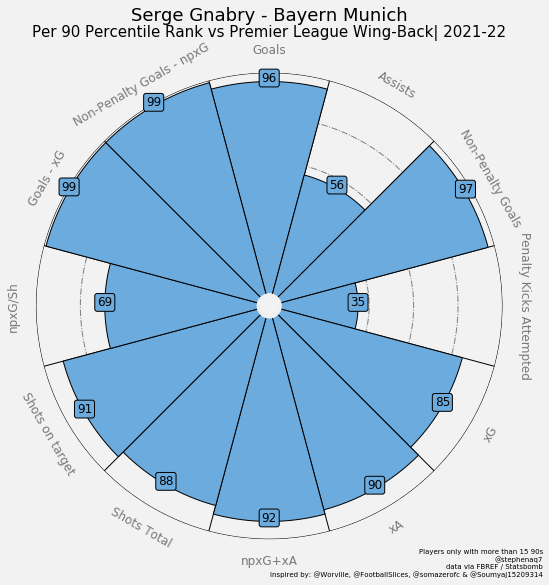

In [162]:
create_pizza_chart(EU_TOP_5_DB,"Serge Gnabry",attacking)

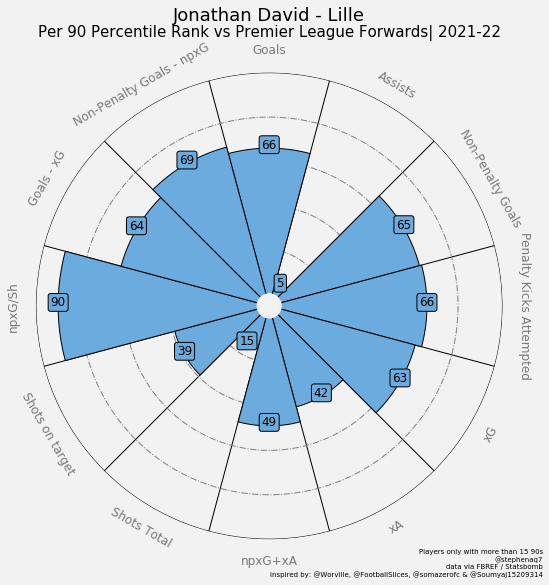

In [76]:
create_pizza_chart(EU_TOP_5_DB,"Jonathan David",attacking)

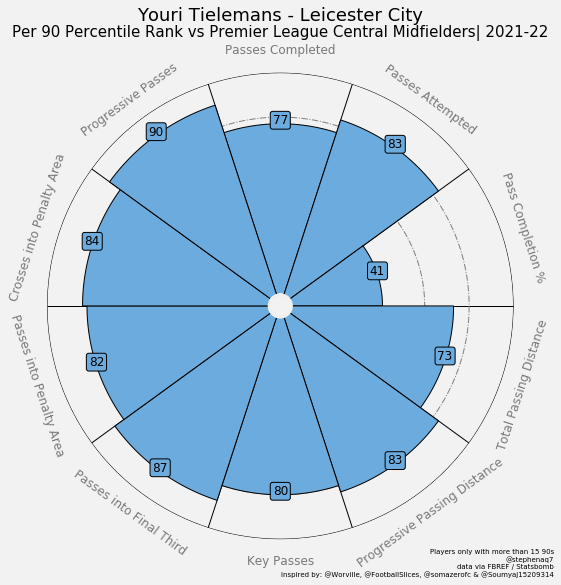

In [54]:
create_pizza_chart(EU_TOP_5_DB,"Youri Tielemans",passing)

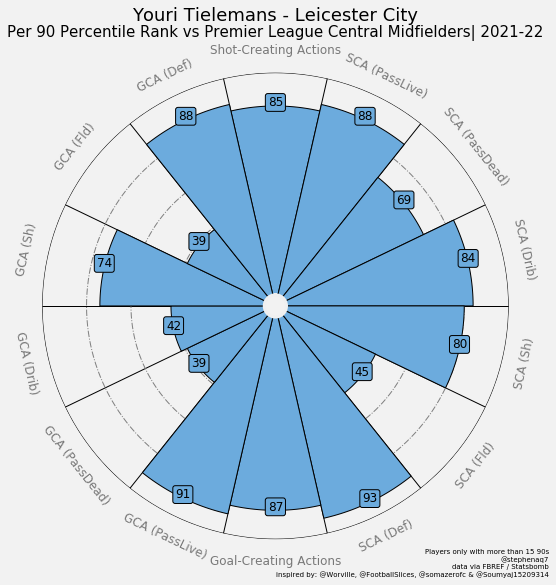

In [55]:
create_pizza_chart(EU_TOP_5_DB,"Youri Tielemans",chance_creation)

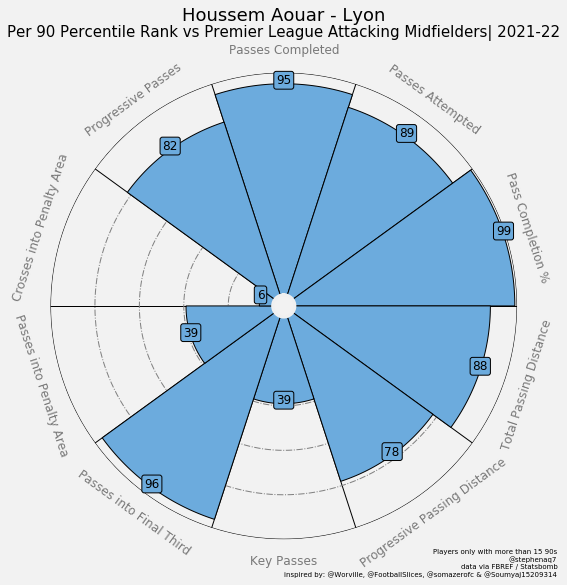

In [56]:
create_pizza_chart(EU_TOP_5_DB,'Houssem Aouar',passing)

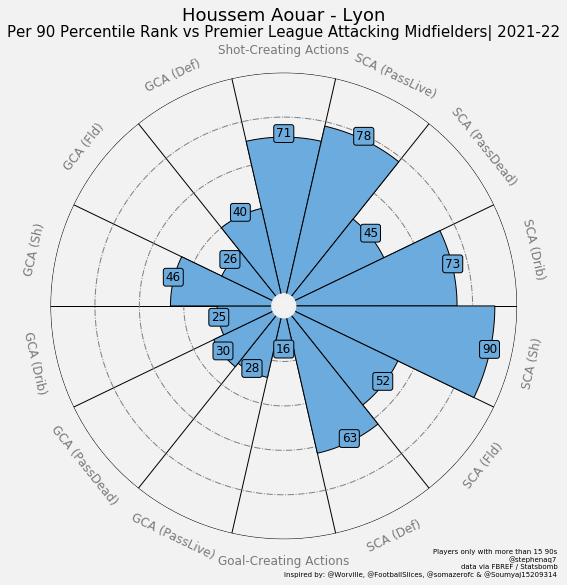

In [58]:
create_pizza_chart(EU_TOP_5_DB,'Houssem Aouar',chance_creation)

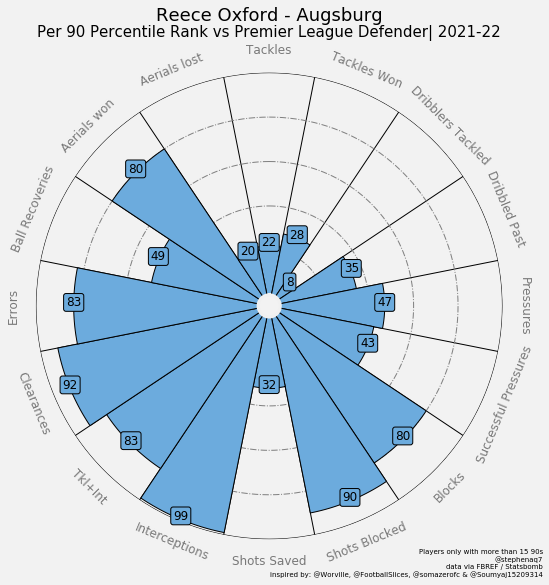

In [73]:
create_pizza_chart(EU_TOP_5_DB,'Reece Oxford',defending)

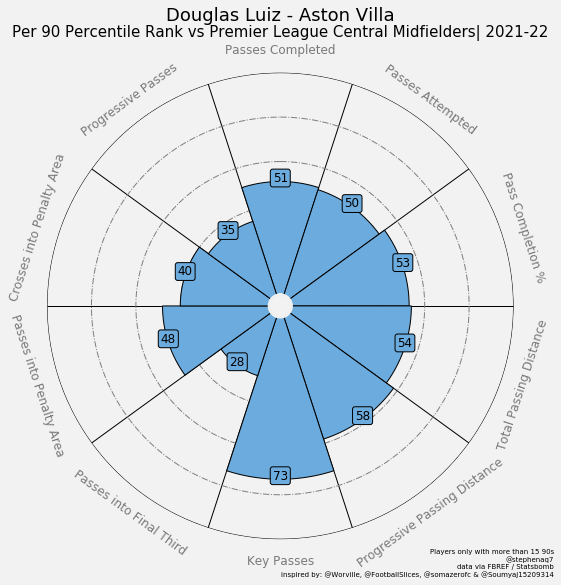

In [70]:
create_pizza_chart(EU_TOP_5_DB,'Douglas Luiz',passing)

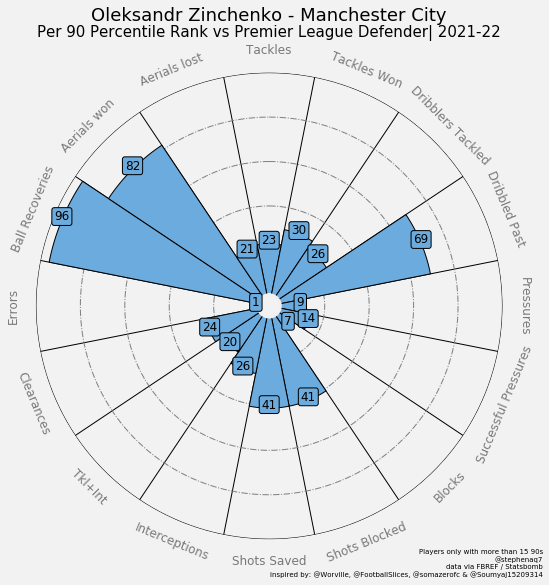

In [171]:
create_pizza_chart(EU_TOP_5_DB,'Oleksandr Zinchenko',defending)

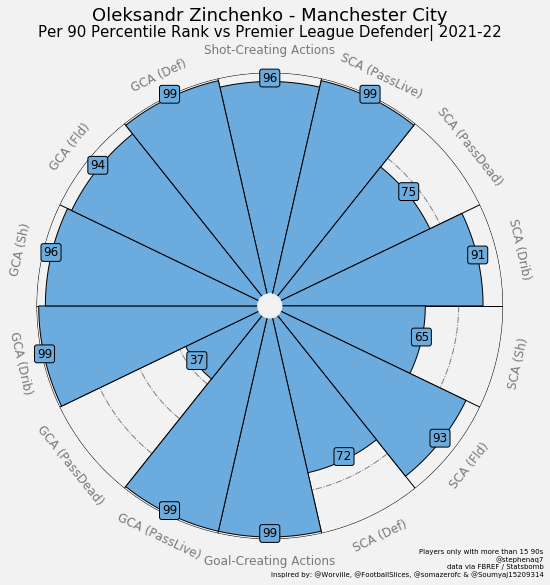

In [172]:
create_pizza_chart(EU_TOP_5_DB,'Oleksandr Zinchenko',chance_creation)

In [ ]:
names = ["Gabriel Jesus","Dominic Calvert-Lewin", "Youri Tielemans", 'Houssem Aouar']

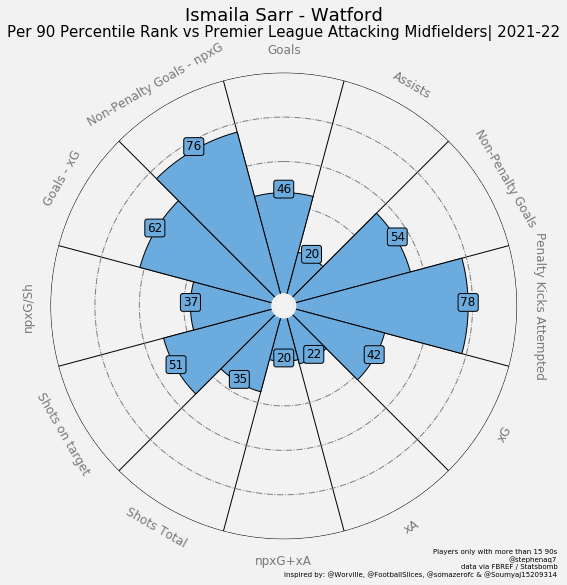

In [74]:
create_pizza_chart(EU_TOP_5_DB,"Ismaila Sarr",attacking)

In [ ]:



import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

df = pd.read_csv("data.csv")

df = df[["Player", "Pos", "90s", "Carries_1/3", "1/3"]]
mf_positions = ['MF']
min_90s = 8
df = df[(df["90s"]>min_90s) & (df["Pos"].isin(mf_positions))].reset_index(drop=True)
df[["Carries_1/3", "1/3"]] = df[["Carries_1/3", "1/3"]].div(df["90s"], axis=0)

xs = StandardScaler().fit_transform(df["Carries_1/3"].values.reshape(-1, 1))
ys = StandardScaler().fit_transform(df["1/3"].values.reshape(-1, 1))

with plt.style.context("custom_viz_dark"):
    fig = plt.figure(figsize=(8,8))

    plot_extents = -2.4, 5.6, -2.4, 5.6
    transform = Affine2D().rotate_deg(45)
    helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    ax.grid(alpha=0.5, linestyle="-.")
    fig.add_subplot(ax)

    ax.scatter(xs, ys, ec='k', alpha=.5, s=50, marker="h")
    ax.set_aspect(1)

    ###highlight top percentile players
    player_names = list(set(df.sort_values("Carries_1/3")["Player"].tail(7).tolist() + df.sort_values("1/3")["Player"].tail(7).tolist()))

    sel_df = df.query("Player == @player_names")
    sel_idx = sel_df.index; player_names = sel_df.Player.tolist()
    sel_xs = xs[sel_idx]; sel_ys = ys[sel_idx]

    ax.scatter(sel_xs, sel_ys, color="dodgerblue", ec="k", alpha=.5, s=70, marker="h")
    for name, x, y in zip(player_names, sel_xs, sel_ys):
        ax.text(x, y, name.split(" ")[-1], fontsize=8, fontstyle="italic")
    ax.axis[:].major_ticklabels.set_alpha(0)

    ax.set(xlabel="Carries into Final Third", ylabel="Passes into Final Third")
    fig.text(x=0.5, y=0.95, s="Ball Progression Profile", fontsize=18, fontweight="light", ha="center")
    fig.text(x=0.5, y=0.9, s= f"Europe's Top 5 Leagues | Position: Midfielders | Minimum minutes: {min_90s*90}", 
        fontsize=12, fontweight="light", ha="center")

fig.savefig("diamond_plot.png", dpi=180)
plt.show()